In [1]:
import joblib
from torchvision import transforms, datasets, models
import sys
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
sys.path.append("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/python_scripts/src")
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)

In [2]:
path2res = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico"
imagenet_val_path = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_data/imagenet"
model_name = "alexnet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

model_cls = getattr(models, model_name)
model = model_cls(pretrained=True).to(device).eval()

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
layers = get_relevant_output_layers(model_name)
layer_idx = 0
layer_name = layers[layer_idx]
print(layer_name)

features.0


In [5]:
feature_extractor = create_feature_extractor(
    model, return_nodes=[layer_name]
).to(device)

In [8]:
path2components = f"{path2res}/imagenet_val_{model_name}_{layer_name}_maxpool_pca_model_1000_PCs.pkl"
PCs = joblib.load(path2components)

In [9]:
evecs = PCs.components_

In [10]:
raw_transform = transforms.ToTensor()
loader = DataLoader(
    datasets.ImageFolder(imagenet_val_path, transform=transform),
    batch_size=1,
    pin_memory=True,
    num_workers=1,
    timeout=100,
)  # shuffle=True, took out bc I want my feats aligned
transform2 = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
loader2 = DataLoader(
    datasets.ImageFolder(imagenet_val_path, transform=transform2),
    batch_size=1,
    pin_memory=True,
    num_workers=1,
    timeout=100,
    shuffle=True,
)  # shuffle=True, took out bc I want my feats aligned


In [11]:
PC1_2 = evecs[:2, :]

In [166]:
n_imgs = 100
counter = 0
collected_feats = []
imgs = []
iter_loader2 = iter(loader2)
for inputs, _ in loader:
    with torch.no_grad():
        raw_inputs, _ = next(iter_loader2)
        imgs.append(np.squeeze(raw_inputs).permute(1,2,0).numpy())
        inputs = inputs.to(device)
        feats = feature_extractor(inputs)[layer_name]
        #feats = feats.view(feats.size(0), -1).cpu().numpy()
        feats = np.max(feats.cpu().numpy(), axis=(2,3))
        collected_feats.append(feats)
    counter += 1
    if counter == n_imgs:
        break
data_pts = np.concatenate(collected_feats, axis=0)

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
python(48028) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(48034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [167]:
data_proj = data_pts @ PC1_2.T # if it were NxD it would have been data.T @ PCs (we're projecting onto the column space), the result is pts x d

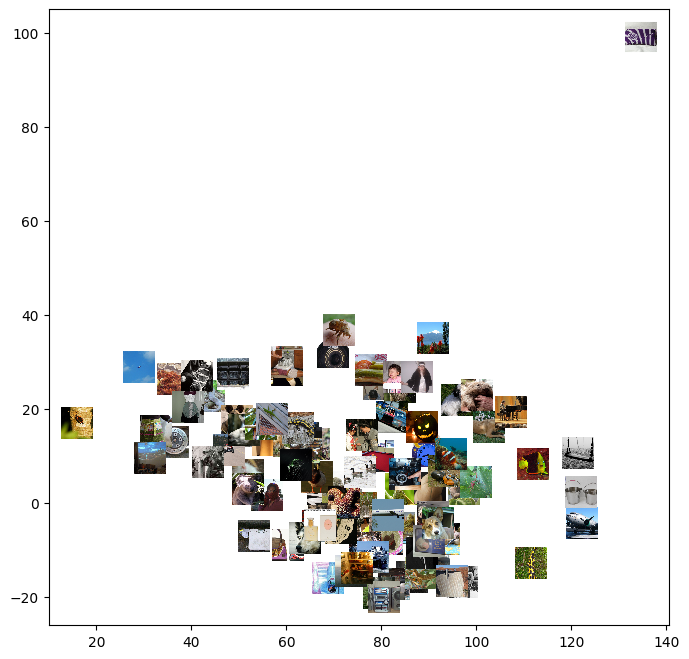

In [168]:
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot (optional if you only want images)
ax.scatter(data_proj[:, 0], data_proj[:, 1], alpha=0.3)
for (x, y), img in zip(data_proj, imgs):
    imagebox = OffsetImage(img, zoom=0.1, alpha=1)  # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)
path2figs = "/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs"
plt.savefig(f"{path2figs}/PCs_space_{model_name}_{layer_name}.png")